In [25]:
library(cellAlign)
library(glue)
library(pheatmap)
library(RColorBrewer)
library(reshape2)
library(scales)

In [6]:
# functions
get_expr_traj <- function(df, traj_file) {
    df_time = read.table(traj_file, row.names=1, header=T, sep='\t')
    df_time = df_time[order(df_time$pseudotime), , drop=F]
    traj = df_time$pseudotime
    names(traj) <- row.names(df_time)
    expr= df_data[, row.names(df_time)]
    l <- list()
    l[['Traj']] = traj
    l[['Expr']] = expr
    return (l)
}

interWeights_inhouse = function(expDataBatch, trajCond, winSz, numPts) {
    trajValNewPts = seq(from = min(trajCond), to = max(trajCond),
        length.out = numPts)
    ValNewPts = do.call("cbind", lapply(trajValNewPts, function(trajPt) {
        dist2Others = trajCond - trajPt
        weightedData = exp(-(dist2Others^2)/(winSz^2))
        weightedData = weightedData/sum(weightedData)
        return(as.matrix(expDataBatch) %*% weightedData)
    }))
}

scaleInterpolate_inhouse = function(interDataConds) {
    scaledData = do.call("rbind", lapply(1:nrow(interDataConds),
        function(rowInd) {
            minVal = min(interDataConds[rowInd,])
            maxVal = max(interDataConds[rowInd,])
            scaledData = (interDataConds[rowInd,] - minVal)/(maxVal - minVal)
            return(rbind(scaledData))
        }))
}

In [8]:
numPts = 200 # Number of bins
winSz = 100  # window size
# load expression matrix
df_data = read.table('/data/yuchen_data/Stereo_seq/All_Figures/Figure2/1.data/Naive_GC_data.txt', row.names=1, sep='\t')
df_data[1:3, 1:3]

,ST2740P_BIN.103537,ST2740P_BIN.104067,ST2740P_BIN.107778
,<dbl>,<dbl>,<dbl>
CCL19,2.940705,2.715423,0
CCL21,2.299038,2.342511,0
FDCSP,0.000000,0.000000,0


In [9]:
# Load pseudotime information and extract expression information for each group
df_ref_time = read.table('/data/yuchen_data/Stereo_seq/All_Figures/Figure2/1.data/Mature.pseudotime.txt', row.names=1, header=T, sep='\t')
df_ref_time = df_ref_time[order(df_ref_time$pseudotime), , drop=F]
trajRef = df_ref_time$pseudotime
names(trajRef) <- row.names(df_ref_time)
expRef = df_data[, row.names(df_ref_time)]

l_dev = get_expr_traj(df_data, '/data/yuchen_data/Stereo_seq/All_Figures/Figure2/1.data/Developing.pseudotime.txt')
l_nm = get_expr_traj(df_data, '/data/yuchen_data/Stereo_seq/All_Figures/Figure2/1.data/NotMature.pseudotime.txt')
exprDev = l_dev[['Expr']]
trajDev = l_dev[['Traj']]
exprNm = l_nm[['Expr']]
trajNm = l_nm[['Traj']]


used_genes = intersect(row.names(expRef)[rowSums(expRef) > 0], row.names(exprDev)[rowSums(exprDev) > 0])
used_genes = intersect(used_genes, row.names(exprNm)[rowSums(exprNm) > 0])
used_genes = used_genes[!(grepl('^IGK', used_genes) | grepl('^IGH', used_genes) | grepl('^IGL', used_genes) | grepl('^LINC', used_genes) | grepl('^AC\\d+.', used_genes) | grepl('^TRA', used_genes) | grepl('^TRB', used_genes) | grepl('^TRG', used_genes) | grepl('^TRD', used_genes) | grepl('-AS1', used_genes) | grepl('^AL\\d+.', used_genes) | grepl('^AP\\d+.', used_genes))]
expRef = expRef[used_genes, ]
exprDev = exprDev[used_genes, ]
exprNm = exprNm[used_genes, ]

In [10]:
# Bin处理并填充,获得traj information
expRef = cellAlign::interWeights(expDataBatch = expRef, trajCond = trajRef,
                                         winSz = 100, numPts = numPts)
traj_ref_cur = expRef$traj

exprDev = cellAlign::interWeights(expDataBatch = exprDev, trajCond = trajDev,
                                         winSz = 95, numPts = numPts)
traj_dev_cur = exprDev$traj

exprNm = cellAlign::interWeights(expDataBatch = exprNm, trajCond = trajNm,
                                         winSz = 100, numPts = numPts)
traj_nm_cur = exprNm$traj

In [12]:
df_ref_time = read.table('/data/yuchen_data/Stereo_seq/All_Figures/Figure2/1.data/Mature.pseudotime.txt', row.names=1, header=T, sep='\t')
df_ref_time = df_ref_time[order(df_ref_time$pseudotime), , drop=F]
trajRef = df_ref_time$pseudotime
names(trajRef) <- row.names(df_ref_time)
expRef = df_data[, row.names(df_ref_time)]

l_dev = get_expr_traj(df_data, '/data/yuchen_data/Stereo_seq/All_Figures/Figure2/1.data/Developing.pseudotime.txt')
l_nm = get_expr_traj(df_data, '/data/yuchen_data/Stereo_seq/All_Figures/Figure2/1.data/NotMature.pseudotime.txt')
exprDev = l_dev[['Expr']]
trajDev = l_dev[['Traj']]
exprNm = l_nm[['Expr']]
trajNm = l_nm[['Traj']]
used_genes = intersect(row.names(expRef)[rowSums(expRef) > 0], row.names(exprDev)[rowSums(exprDev) > 0])
used_genes = intersect(used_genes, row.names(exprNm)[rowSums(exprNm) > 0])
used_genes = used_genes[!(grepl('^IGK', used_genes) | grepl('^IGH', used_genes) | grepl('^IGL', used_genes) | grepl('^LINC', used_genes) | grepl('^AC\\d+.', used_genes) | grepl('^TRA', used_genes) | grepl('^TRB', used_genes) | grepl('^TRG', used_genes) | grepl('^TRD', used_genes) | grepl('-AS1', used_genes) | grepl('^AL\\d+.', used_genes) | grepl('^AP\\d+.', used_genes))]
expRef = expRef[used_genes, ]
exprDev = exprDev[used_genes, ]
exprNm = exprNm[used_genes, ]

# scale the Conforming and Deviating expressioin matrix together
expRef_inouse = interWeights_inhouse(expDataBatch = expRef, trajCond = trajRef,
                                         winSz = winSz, numPts = numPts)

exprDev_inouse = interWeights_inhouse(expDataBatch = exprDev, trajCond = trajDev,
                                         winSz = winSz, numPts = numPts)

exprNm_inouse = interWeights_inhouse(expDataBatch = exprNm, trajCond = trajNm,
                                         winSz = winSz, numPts = numPts)
# scale
expRef_scaled = scaleInterpolate_inhouse(expRef_inouse)

expr_tmp_inhouse = cbind(exprDev_inouse, exprNm_inouse)
expr_tmp_scaled_inhouse = scaleInterpolate_inhouse(expr_tmp_inhouse)
exprDev_scaled_inhouse = expr_tmp_scaled_inhouse[, 1:200]
exprNm_scaled_inhouse = expr_tmp_scaled_inhouse[, 201:400]

In [14]:
# calculate distance
A1=calcDistMat(exprDev_scaled_inhouse, expRef_scaled,dist.method = "Euclidean")
A2=calcDistMat(exprNm_scaled_inhouse, expRef_scaled,dist.method = "Euclidean")
A1[1:3, 1:3]

8.468658,8.375791,8.288258
8.482222,8.387346,8.297723
8.498469,8.401589,8.309880


In [21]:
A1_matrix <- `dim<-`(c(A1), dim(A1))
A1_plot = melt(A1_matrix)
A1_plot$Var1 = - A1_plot$Var1
A1_plot = subset(A1_plot, subset= Var1>= -190 & Var2 <= 190)


A2_matrix <- `dim<-`(c(A2), dim(A2))
A2_plot = melt(A2_matrix)
A2_plot$Var1 = - A2_plot$Var1
A2_plot = subset(A2_plot, subset=Var1>= -190 & Var2 <= 190 )

head(A1_plot)

,Var1,Var2,value
,<int>,<int>,<dbl>
1,-1,1,8.468658
2,-2,1,8.482222
3,-3,1,8.498469
4,-4,1,8.517482
5,-5,1,8.539336
6,-6,1,8.564099


In [22]:
A1_curve = read.csv('/data/yuchen_data/Stereo_seq/All_Figures/Figure2/1.data/DevelopingDistance.optimal_field.central_line.csv', row.names=1, header=T, sep=',')
# A1_curve转换格式
A1_curv1_plot = which(A1_curve != 0, arr.ind = T)
A1_curv1_plot = as.data.frame(A1_curv1_plot)
A1_curv1_plot$row = -A1_curv1_plot$row

A2_curve = read.csv('/data/yuchen_data/Stereo_seq/All_Figures/Figure2/1.data/NotMatureDistance.optimal_field.central_line.csv', row.names=1, header=T, sep=',')
# A1_curve转换格式
A2_curv1_plot = which(A2_curve != 0, arr.ind = T)
A2_curv1_plot = as.data.frame(A2_curv1_plot)
A2_curv1_plot$row = -A2_curv1_plot$row
# v_min = 7
# v_max = 17

v_min = min(c(A1_plot$value, A2_plot$value))
v_max = max(c(A1_plot$value, A2_plot$value))

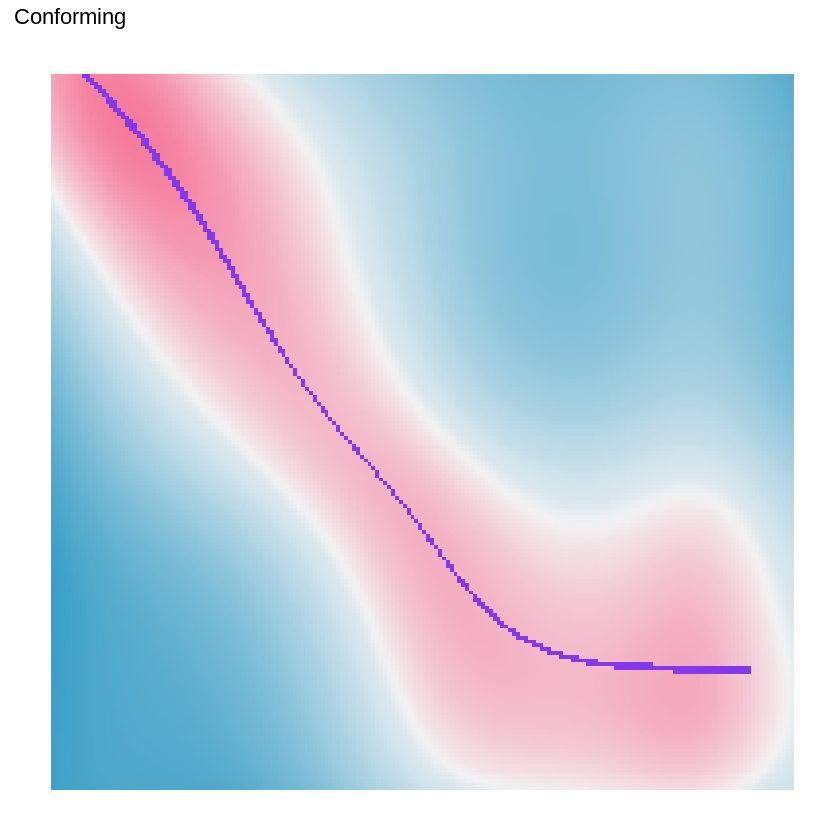

In [27]:
color_1 = c('#329ac4','#359cc5','#399ec6','#3c9fc7','#40a1c8','#43a3c8','#48a5ca','#4ca7cb','#4fa8cb','#54aacc','#57abcd','#5badce','#60afcf','#63b1d0','#67b3d1','#6ab4d2','#6fb6d3','#71b8d4','#76bad5','#7abcd6','#7dbdd7','#82bfd8','#85c0d8','#89c2d9','#8ec4db','#91c6db','#96c8dd','#99cadd','#9dccde','#a0cddf','#a5cfe0','#a9d1e1','#acd2e2','#b1d4e3','#b4d6e4','#b8d8e5','#bddae6','#bfdbe7','#c4dde8','#c7dee8','#cbe1ea','#d0e3eb','#d3e4eb','#d7e6ec','#dae7ed','#dfe9ee','#e2ebef','#e6edf0','#ebeff1','#eef0f2','#f2efef','#f2ecee','#f2e9eb','#f2e5e9','#f2e3e7','#f3dfe4','#f3dde2','#f3d9e0','#f3d7de','#f3d3dc','#f3d0d9','#f3cdd7','#f3c9d5','#f3c7d3','#f3c3d0','#f3c0ce','#f3bdcc','#f4bac9','#f4b7c8','#f4b4c5','#f4b0c2','#f4aec1','#f4aabe','#f4a8bc','#f4a4ba','#f4a1b8','#f49db5','#f49ab2','#f497b1','#f594ae','#f591ac','#f58eaa','#f58aa7','#f588a5','#f584a3','#f582a1','#f57e9f','#f57c9d','#f5789a','#f57498','#f67296','#f66e93','#f66c92','#f6688f','#f6658c','#f6628b','#f65f88','#f65c86','#f65984','#f65682')[1:90]

# Conforming TLS heatmap
ggplot(A1_plot, aes(x=Var2, y=Var1)) +
  geom_tile(aes(fill = value)) +
  scale_fill_gradientn(colors=rev(color_1), limits = c(v_min, v_max), values = rescale(c(v_min, 10.5, v_max)))  + geom_tile(data=A1_curv1_plot, aes(x=col, y=row), fill='#8338EC') + theme(panel.grid = element_blank(),panel.border = element_blank(),
         axis.title = element_blank(),axis.line = element_blank(),
         axis.text = element_blank(),axis.ticks = element_blank(), panel.background=element_blank(),legend.position='none') + ggtitle('Conforming')


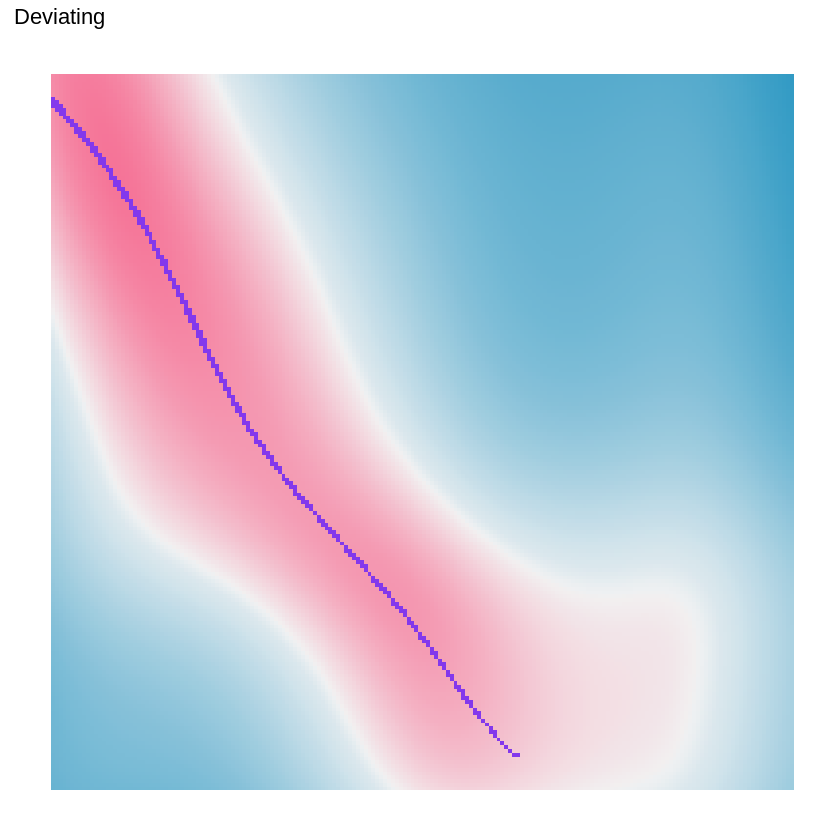

In [28]:
# Deviating TLS heatmap
ggplot(A2_plot, aes(x=Var2, y=Var1)) +
  geom_tile(aes(fill = value)) + scale_fill_gradientn(colors=rev(color_1), limits = c(v_min, v_max), values = rescale(c(v_min, 10.5, v_max))) + geom_tile(data=A2_curv1_plot, aes(x=col, y=row), fill='#8338EC') +theme(panel.grid = element_blank(),panel.border = element_blank(),
         axis.title = element_blank(),axis.line = element_blank(),
         axis.text = element_blank(),axis.ticks = element_blank(), panel.background=element_blank(),legend.position='none') + ggtitle('Deviating')

In [29]:
# calculate the alignment-based distance

alignment_dev = globalAlign(exprDev_scaled_inhouse[1:190, 1:190], expRef_scaled[1:190, 1:190],
                                   scores = list(query = traj_dev_cur[1:190], 
                                                 ref = traj_ref_cur[1:190]),
                                   sigCalc = F, numPerm = 20, normDist=T)

alignment_nm = globalAlign(exprNm_scaled_inhouse[1:190, 1:190], expRef_scaled[1:190, 1:190],
                                   scores = list(query = traj_nm_cur[1:190], 
                                                 ref = traj_ref_cur[1:190]),
                                   sigCalc = F, numPerm = 20, normDist=T)

print(glue('Distance of Conforming TLS = {alignment_dev$distance}'))
print(glue('Distance of Deviating TLS = {alignment_nm$distance}'))

calculate dissimilarity matrix

calculate cost and step matrices

backtracking

calculate dissimilarity matrix

calculate cost and step matrices

backtracking



Distance of Conforming TLS = 38.2825077470441
Distance of Deviating TLS = 50.9136245870569
